In [2]:
import numpy as np
from qiskit.circuit import *
from qiskit.circuit.library import *
from qiskit import Aer, execute
from qiskit.tools.visualization import plot_histogram

Fonction permettant le passage de la superposition au rang $n$ à celle au rang $n+1$ :

In [3]:
def buildNextPathCircuit(n):

    """PARAMETRES"""
    N = n * (n - 1) // 2
    nextN = (n + 1) * n // 2

    edgesToVertex = []
    for i in range(n):
        for j in range(0, i):
            edgesToVertex.append((i, j))

    """CREATION CIRCUIT PRINCIPAL"""
    path = QuantumRegister(nextN, name = "x")
    counter = QuantumRegister(n, name = "n")
    controlPath = QuantumRegister(1, name = "a")
    controlSuperposition = QuantumRegister(1, name = "b")

    circuit = QuantumCircuit(path, controlPath,
                             controlSuperposition,
                             counter,
                             name = "circuit " + str(n) + " -> " +
                             str(n + 1))

    circuit.swap(counter[0], counter[-1])

    circuit.barrier()
    circuit.barrier()

    """BOUCLE GENERALE"""
    for e in range(N):
        j, k = edgesToVertex[e]

        #Incrémentation du compteur
        for ii in range(1, n):
            i = n - ii
            circuit.cswap(path[e], counter[i], counter[i - 1])

        circuit.append(CCXGate(ctrl_state = "10"),
                               [controlSuperposition[0],
                               path[e], controlPath[0]])

        circuit.barrier()

        #Boucle qui change l'arête si besoin en controllant et lui applique la bonne superposition en fonction du compteur
        for i in range(0, n):

            gateSupr = RYGate(2 * np.arcsin(1 / np.sqrt(n - i)))

            ctrlGateSupr = gateSupr.control(2, ctrl_state = "11")
            circuit.append(ctrlGateSupr, [controlPath[0],
                           counter[i], path[e]])

        gateNew = CCXGate(ctrl_state = "01")
        circuit.append(gateNew, [controlPath[0], path[e], path[N + j]])

        circuit.append(gateNew, [controlPath[0], path[e], path[N + k]])

        circuit.barrier()

        circuit.append(CCXGate(ctrl_state = "11"), [path[N + j],
                                path[N + k], controlSuperposition[0]])

        circuit.append(C3XGate(ctrl_state = "110"), [path[e],
                                path[N + j], path[N + k],
                                controlPath[0]])

        circuit.append(CCXGate(ctrl_state = "10"),
                                [controlSuperposition[0],
                                path[e],
                                controlPath[0]])

        circuit.barrier()
        circuit.barrier()

    """REINITIALISATION"""
    circuit.x(controlSuperposition[0])
    circuit.swap(counter[0], counter[-1])

    return circuit

Fonction construisant la superposition désirée itérativement, par appels successifs à 'buildNextPathCircuit', avec 3 comme cas de base :

In [4]:
def buildCircuitPath(n):
    N = n * (n - 1) // 2

    path = QuantumRegister(N, name = "x")
    counter = QuantumRegister(n - 1, name = "n")
    controlPath = QuantumRegister(1, name  = "a")
    controlSuperposition = QuantumRegister(1, name = "b")

    #cPath = ClassicalRegister(n * (n - 1) // 2, name = "cX")

    circuit = QuantumCircuit(path, controlPath, controlSuperposition,
                             counter, name = "Superposition")

    """INITIALISATION COMPTEUR + CHEMIN POUR 3"""
    circuit.x(path[:3])
    circuit.x(counter[0])

    circuit.barrier()

    """CONSTRUCTIONS SUCCESSIVES"""
    for i in range(3, n):
        Ni = i * (i + 1) // 2

        circuit.append(buildNextPathCircuit(i), path[:Ni] +
                                                controlPath[:] +
                                                controlSuperposition[:] +
                                                counter[:i])
        circuit.barrier()

    #circuit.measure(path, cPath)

    return circuit

Choix du backend et ajout du registre classique permettant la mesure :

In [4]:
backend = Aer.get_backend('qasm_simulator')
circuit = buildCircuitPath(5)
cPath = ClassicalRegister(10)
circuit.add_register(cPath)
circuit.measure(range(10), cPath)

Exécution du circuit sur simulateur et affichage des résultats :

{'0101011100': 83304, '0101110001': 83104, '0110011010': 83432, '0110101001': 83081, '1001010110': 83524, '1001100101': 83262, '1010001110': 83330, '1010100011': 83052, '1100001101': 83556, '1100010011': 83814, '0011101100': 83140, '0011110010': 83401}


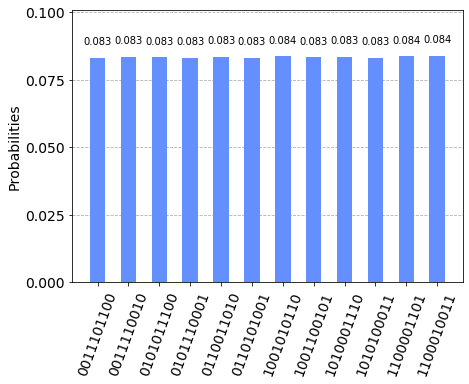

In [5]:
results = execute(circuit, backend, shots = 1000000).result()
print(results.get_counts(circuit))
plot_histogram(results.get_counts(circuit))